<a href="https://colab.research.google.com/github/ibrahimmina/TrafficAnalyzer/blob/main/SDPv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import glob
import os
import numpy as np
from datetime import datetime
import logging
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive/Colab Notebooks/SDP Stats/sdp_stat_files/"

In [ ]:
def getMemberCIPDiameterData(sdp,member):


  dir_name = base_dir + sdp + "/" + member + "/PSC-CIPDiameter*.stat.[0-9]"

  CIPDiameter = sorted( filter( os.path.isfile,
                          glob.glob(dir_name) ) )

  CIPDiameter.reverse()

  UnweightedDF = pd.DataFrame()


  if not CIPDiameter:
    logging.warning('No CIP Diameter Files Available for SDP: ' + sdp + " Member: " + member)
    return UnweightedDF

  prefinaldf = pd.DataFrame()

  for filename in CIPDiameter:
    df = pd.read_csv(filename,   sep = "\s+|\t+|\s+\t+|\t+\s+" , on_bad_lines='warn', engine='python', header=None, names = ['DateTime' , 'TrafficCase', 'Succ' , 'Fail', 'Timeout', 'Reject', 'Retransmission Detected', 'Duplicate Answered', 'Thrput', 'Response time (ms) Avg', 'Response time (ms) Min', 'Response time (ms) Max'])
    prefinaldf = pd.concat([prefinaldf,df])

  prefinaldf['CleanedDate'] = pd.to_datetime(prefinaldf['DateTime'], errors='coerce', format='%y-%m-%d')
  prefinaldf['CleanedTime'] = pd.to_datetime(prefinaldf['DateTime'], errors='coerce', format='%H:%M:%S')
  #prefinaldf['CleanedTime'] = prefinaldf['CleanedTime'].shift(-1)
  prefinaldf['CleanedDate'] = prefinaldf['CleanedDate'].ffill()
  prefinaldf['CleanedTime'] = prefinaldf['CleanedTime'].ffill()

  prefinaldf['CleanedDate'] = prefinaldf['CleanedDate'].dt.strftime('%Y-%m-%d')
  prefinaldf['CleanedTime'] = prefinaldf['CleanedTime'].dt.strftime('%H:%M:%S')
  prefinaldf['FinalDateTime'] = prefinaldf['CleanedDate'] + " " + prefinaldf['CleanedTime'].str[:-1] +"0"
  prefinaldf['FinalDateTime']= pd.to_datetime(prefinaldf['FinalDateTime'], format="%Y-%m-%d %H:%M:%S")
  prefinaldf.dropna(subset = ['FinalDateTime'], inplace = True)
  prefinaldf.drop(['CleanedDate', 'CleanedTime'], axis=1, inplace = True)

  #prefinaldf.reset_index(drop=True,inplace=True)
  prefinaldf.set_index('FinalDateTime',inplace=True)

  #filterDF = prefinaldf[['DateTime' , 'TrafficCase', 'Succ' , 'Fail', 'Timeout', 'Reject', 'Retransmission Detected', 'Duplicate Answered', 'Thrput', 'Response time (ms) Avg', 'Response time (ms) Min', 'Response time (ms) Max']]

  #diameterDF = filterDF[filterDF['TrafficCase'] == "Diameter"].shift(-1, axis = 1)

  #filterDF.update(diameterDF)
  #finalDF = pd.concat([filterDF,prefinaldf['FinalDateTime']], axis=1)

  prefinaldf = prefinaldf.where(prefinaldf['TrafficCase'] != "Diameter",prefinaldf.shift(-1, axis = 1))

  finalDF = prefinaldf.reset_index()

  finalDF.drop(finalDF[finalDF['DateTime'] == "Detected"].index, inplace = True)
  finalDF.drop(finalDF[finalDF['TrafficCase'] == "Name"].index, inplace = True)
  #finalDF.reset_index(drop=True,inplace=True)
  finalDF.rename(columns = {'Response time (ms) Max':'Delete'}, inplace = True)
  finalDF.rename(columns = {'Response time (ms) Min':'Response time (ms) Max'}, inplace = True)
  finalDF.rename(columns = {'Response time (ms) Avg':'Response time (ms) Min'}, inplace = True)
  finalDF.rename(columns = {'Thrput':'Response time (ms) Avg'}, inplace = True)
  finalDF.rename(columns = {'Duplicate Answered':'Thrput'}, inplace = True)
  finalDF.rename(columns = {'Retransmission Detected':'Duplicate Answered'}, inplace = True)
  finalDF.rename(columns = {'Reject':'Retransmission Detected'}, inplace = True)
  finalDF.rename(columns = {'Timeout':'Reject'}, inplace = True)
  finalDF.rename(columns = {'Fail':'Timeout'}, inplace = True)
  finalDF.rename(columns = {'Succ':'Fail'}, inplace = True)
  finalDF.rename(columns = {'TrafficCase':'Succ'}, inplace = True)
  finalDF.rename(columns = {'DateTime':'TrafficCase'}, inplace = True)
  finalDF.rename(columns = {'FinalDateTime':'DateTime'}, inplace = True)
  #finalDF['DateTime'] = finalDF['DateTime'].dt.round('5S')

  UnweightedDF = finalDF.pivot(index='DateTime', columns='TrafficCase', values='Thrput')

  DiameterKPIDF = finalDF[finalDF['TrafficCase'] == "Diameter"]
  DiameterKPIDF = DiameterKPIDF[["DateTime", "Succ", "Reject", "Response time (ms) Avg"]]
  DiameterKPIDF.set_index('DateTime', inplace = True)

  UnweightedDF = pd.concat([UnweightedDF,DiameterKPIDF], axis=1)

  return UnweightedDF

In [ ]:
def getSDPPPASMemberData(sdp,member):
  dir_name = base_dir + sdp + "/" + member + "/PSC-PPASInterface*.stat.[0-9]"

  PPASInterface = sorted( filter( os.path.isfile,
                          glob.glob(dir_name) ) )

  PPASInterface.reverse()

  UnweightedDFppas = pd.DataFrame()

  if not PPASInterface:
    logging.warning('No PPAS Diameter Files Available for SDP: ' + sdp + " Member: " + member)
    return UnweightedDFppas

  prefinaldfppas = pd.DataFrame()

  for filename in PPASInterface:
    df = pd.read_csv(filename,   sep = "\s+|\t+|\s+\t+|\t+\s+" , on_bad_lines='warn', engine='python', header=None, names = ['DateTime' , 'TrafficCase', 'Succ' , 'Fail', 'Reject', 'Thrput', 'Response time (ms) Avg', 'Response time (ms) Min', 'Response time (ms) Max'])
    prefinaldfppas = pd.concat([prefinaldfppas,df])

  prefinaldfppas['CleanedDate'] = pd.to_datetime(prefinaldfppas['DateTime'], errors='coerce', format='%y-%m-%d')
  prefinaldfppas['CleanedTime'] = pd.to_datetime(prefinaldfppas['DateTime'], errors='coerce', format='%H:%M:%S')
  prefinaldfppas['CleanedDate'] = prefinaldfppas['CleanedDate'].ffill()
  prefinaldfppas['CleanedTime'] = prefinaldfppas['CleanedTime'].ffill()

  prefinaldfppas['CleanedDate'] = prefinaldfppas['CleanedDate'].dt.strftime('%Y-%m-%d')
  prefinaldfppas['CleanedTime'] = prefinaldfppas['CleanedTime'].dt.strftime('%H:%M:%S')
  prefinaldfppas['FinalDateTime'] = prefinaldfppas['CleanedDate'] + " " + prefinaldfppas['CleanedTime'].str[:-1] +"0"

  prefinaldfppas['FinalDateTime']= pd.to_datetime(prefinaldfppas['FinalDateTime'], format="%Y-%m-%d %H:%M:%S")
  prefinaldfppas.dropna(subset = ['FinalDateTime'], inplace = True)
  prefinaldfppas.drop(['CleanedDate', 'CleanedTime'], axis=1, inplace = True)
  prefinaldfppas.reset_index(drop=True,inplace=True)

  prefinaldfppas.drop(prefinaldfppas[prefinaldfppas['TrafficCase'] == "Total"].index, inplace = True)
  prefinaldfppas.drop(prefinaldfppas[prefinaldfppas['TrafficCase'] == "Name"].index, inplace = True)
  prefinaldfppas.drop(prefinaldfppas[prefinaldfppas['TrafficCase'] == "Avg"].index, inplace = True)

  prefinaldfppas.reset_index(drop=True,inplace=True)
  prefinaldfppas.rename(columns = {'Response time (ms) Max':'Delete'}, inplace = True)
  prefinaldfppas.rename(columns = {'Response time (ms) Min':'Response time (ms) Max'}, inplace = True)
  prefinaldfppas.rename(columns = {'Response time (ms) Avg':'Response time (ms) Min'}, inplace = True)
  prefinaldfppas.rename(columns = {'Thrput':'Response time (ms) Avg'}, inplace = True)
  prefinaldfppas.rename(columns = {'Reject':'Thrput'}, inplace = True)
  prefinaldfppas.rename(columns = {'Fail':'Reject'}, inplace = True)
  prefinaldfppas.rename(columns = {'Succ':'Fail'}, inplace = True)
  prefinaldfppas.rename(columns = {'TrafficCase':'Succ'}, inplace = True)
  prefinaldfppas.rename(columns = {'DateTime':'TrafficCase'}, inplace = True)
  prefinaldfppas.rename(columns = {'FinalDateTime':'DateTime'}, inplace = True)

  UnweightedDFppas = prefinaldfppas.pivot_table(index='DateTime', columns='TrafficCase', values='Thrput', aggfunc='sum')
  UnweightedDFppas = UnweightedDFppas.fillna(0)

  return UnweightedDFppas


In [ ]:
def getSDPLDAPMemberData(sdp,member):
  dir_name = base_dir + sdp + "/" + member + "/PSC-LDAP*.stat.[0-9]"
  LDAP = sorted( filter( os.path.isfile,
                          glob.glob(dir_name) ) )

  LDAP.reverse()

  UnweightedDFldap = pd.DataFrame()

  if not LDAP:
    logging.warning('No LDAP Files Available for SDP: ' + sdp + " Member: " + member)
    return UnweightedDFldap

  prefinaldfldap = pd.DataFrame()

  for filename in LDAP:
    df = pd.read_csv(filename,   sep = "\s+|\t+|\s+\t+|\t+\s+" , on_bad_lines='warn', engine='python', header=None, names = ['DateTime' , 'TrafficCase', 'Succ' , 'Fail', 'Reject', 'Thrput', 'Response time (ms) Avg', 'Response time (ms) Min', 'Response time (ms) Max'])
    prefinaldfldap = pd.concat([prefinaldfldap,df])

  prefinaldfldap['CleanedDate'] = pd.to_datetime(prefinaldfldap['DateTime'], errors='coerce', format='%y-%m-%d')
  prefinaldfldap['CleanedTime'] = pd.to_datetime(prefinaldfldap['DateTime'], errors='coerce', format='%H:%M:%S')
  prefinaldfldap['CleanedDate'] = prefinaldfldap['CleanedDate'].ffill()
  prefinaldfldap['CleanedTime'] = prefinaldfldap['CleanedTime'].ffill()

  prefinaldfldap['CleanedDate'] = prefinaldfldap['CleanedDate'].dt.strftime('%Y-%m-%d')
  prefinaldfldap['CleanedTime'] = prefinaldfldap['CleanedTime'].dt.strftime('%H:%M:%S')
  prefinaldfldap['FinalDateTime'] = prefinaldfldap['CleanedDate'] + " " + prefinaldfldap['CleanedTime'].str[:-1] +"0"

  prefinaldfldap['FinalDateTime']= pd.to_datetime(prefinaldfldap['FinalDateTime'], format="%Y-%m-%d %H:%M:%S")
  prefinaldfldap.dropna(subset = ['FinalDateTime'], inplace = True)
  prefinaldfldap.drop(['CleanedDate', 'CleanedTime'], axis=1, inplace = True)
  prefinaldfldap.reset_index(drop=True,inplace=True)

  prefinaldfldap = prefinaldfldap[prefinaldfldap['TrafficCase'] == "Searches"]

  UnweightedDFldap = prefinaldfldap[['FinalDateTime', 'Thrput']]
  UnweightedDFldap = UnweightedDFldap.fillna(0)
  UnweightedDFldap.rename(columns = {'FinalDateTime':'DateTime'}, inplace = True)
  UnweightedDFldap.rename(columns = {'Thrput':'Thrput-ldap'}, inplace = True)
  UnweightedDFldap.set_index('DateTime', inplace = True)

  return UnweightedDFldap

In [ ]:
def getSDPSMSMemberData(sdp,member):
  dir_name = base_dir + sdp + "/" + member + "/FSC-SMSInterface*.stat.[0-9]"

  SMS = sorted( filter( os.path.isfile,
                        glob.glob(dir_name) ) )

  SMS.reverse()

  UnweightedDFsms = pd.DataFrame()

  if not SMS:
    logging.warning('No SMS Files Available for SDP: ' + sdp + " Member: " + member)
    return UnweightedDFsms

  prefinaldfsms = pd.DataFrame()

  for filename in SMS:
    df = pd.read_csv(filename,   sep = "\s+|\t+|\s+\t+|\t+\s+" , on_bad_lines='warn', engine='python', header=None, names = ['DateTime' , 'TrafficCase', 'Succ' , 'Fail', 'Reject', 'Thrput', 'Response time (ms) Avg', 'Response time (ms) Min', 'Response time (ms) Max'])
    prefinaldfsms = pd.concat([prefinaldfsms,df])

  prefinaldfsms['CleanedDate'] = pd.to_datetime(prefinaldfsms['DateTime'], errors='coerce', format='%y-%m-%d')
  prefinaldfsms['CleanedTime'] = pd.to_datetime(prefinaldfsms['DateTime'], errors='coerce', format='%H:%M:%S')
  prefinaldfsms['CleanedDate'] = prefinaldfsms['CleanedDate'].ffill()
  prefinaldfsms['CleanedTime'] = prefinaldfsms['CleanedTime'].ffill()

  prefinaldfsms['CleanedDate'] = prefinaldfsms['CleanedDate'].dt.strftime('%Y-%m-%d')
  prefinaldfsms['CleanedTime'] = prefinaldfsms['CleanedTime'].dt.strftime('%H:%M:%S')
  prefinaldfsms['FinalDateTime'] = prefinaldfsms['CleanedDate'] + " " + prefinaldfsms['CleanedTime'].str[:-1] +"0"

  prefinaldfsms['FinalDateTime']= pd.to_datetime(prefinaldfsms['FinalDateTime'], format="%Y-%m-%d %H:%M:%S")
  prefinaldfsms.dropna(subset = ['FinalDateTime'], inplace = True)
  prefinaldfsms.drop(['CleanedDate', 'CleanedTime'], axis=1, inplace = True)
  prefinaldfsms.reset_index(drop=True,inplace=True)

  prefinaldfsms = prefinaldfsms[prefinaldfsms['TrafficCase'] == "Total"]

  UnweightedDFsms = prefinaldfsms[['FinalDateTime', 'Thrput']]
  UnweightedDFsms = UnweightedDFsms.fillna(0)
  UnweightedDFsms.rename(columns = {'FinalDateTime':'DateTime'}, inplace = True)
  UnweightedDFsms.rename(columns = {'Thrput':'Thrput-SMS'}, inplace = True)
  UnweightedDFsms.set_index('DateTime', inplace = True)

  return UnweightedDFsms

In [ ]:
def getSDPUSSDMemberData(sdp,member):
  dir_name = base_dir + sdp + "/" + member + "/FSC-UssdHD*.stat.[0-9]"

  USSD = sorted( filter( os.path.isfile,
                          glob.glob(dir_name) ) )

  USSD.reverse()

  UnweightedDFussd = pd.DataFrame()

  if not USSD:
    logging.warning('No USSD Files Available for SDP: ' + sdp + " Member: " + member)
    return UnweightedDFussd

  prefinaldfussd = pd.DataFrame()

  for filename in USSD:
    df = pd.read_csv(filename,   sep = "\s+|\t+|\s+\t+|\t+\s+" , on_bad_lines='warn', engine='python', header=None, names = ['DateTime' , 'TrafficCase', "Delete", 'Succ' , 'Fail', 'Reject', 'Thrput', 'Response time (ms) Avg', 'Response time (ms) Min', 'Response time (ms) Max'])
    prefinaldfussd = pd.concat([prefinaldfussd,df])

  prefinaldfussd['CleanedDate'] = pd.to_datetime(prefinaldfussd['DateTime'], errors='coerce', format='%y-%m-%d')
  prefinaldfussd['CleanedTime'] = pd.to_datetime(prefinaldfussd['DateTime'], errors='coerce', format='%H:%M:%S')
  prefinaldfussd['CleanedDate'] = prefinaldfussd['CleanedDate'].ffill()
  prefinaldfussd['CleanedTime'] = prefinaldfussd['CleanedTime'].ffill()

  prefinaldfussd['CleanedDate'] = prefinaldfussd['CleanedDate'].dt.strftime('%Y-%m-%d')
  prefinaldfussd['CleanedTime'] = prefinaldfussd['CleanedTime'].dt.strftime('%H:%M:%S')
  prefinaldfussd['FinalDateTime'] = prefinaldfussd['CleanedDate'] + " " + prefinaldfussd['CleanedTime'].str[:-1] +"0"

  prefinaldfussd['FinalDateTime']= pd.to_datetime(prefinaldfussd['FinalDateTime'], format="%Y-%m-%d %H:%M:%S")
  prefinaldfussd.dropna(subset = ['FinalDateTime'], inplace = True)
  prefinaldfussd.drop(['CleanedDate', 'CleanedTime'], axis=1, inplace = True)
  prefinaldfussd.reset_index(drop=True,inplace=True)

  prefinaldfussd = prefinaldfussd[prefinaldfussd['TrafficCase'] == "Total"]

  UnweightedDFussd = prefinaldfussd[['FinalDateTime', 'Thrput']]
  UnweightedDFussd = UnweightedDFussd.fillna(0)
  UnweightedDFussd.rename(columns = {'FinalDateTime':'DateTime'}, inplace = True)
  UnweightedDFussd.rename(columns = {'Thrput':'Thrput-USSD'}, inplace = True)
  UnweightedDFussd.set_index('DateTime', inplace = True)

  return UnweightedDFussd

In [ ]:
def getSDPUnweightedData(sdp):
  members = ['mema', 'memb']

  UnweightedDFa = pd.DataFrame()

  #Get CIP Diamater Data
  UnweightedDFa = getMemberCIPDiameterData(sdp,"mema")

  max_date = UnweightedDFa.index.max()
  min_date = UnweightedDFa.index.min()

  #Get PPAS Data
  ppasa = getSDPPPASMemberData(sdp,"mema")
  ppasa = ppasa[~ppasa.index.duplicated(keep='first')]
  UnweightedDFa = pd.concat([UnweightedDFa,ppasa], axis=1)

  #Get SMS Data
  smsa = getSDPSMSMemberData(sdp,"mema")
  smsa = smsa[~smsa.index.duplicated(keep='first')]
  UnweightedDFa = pd.concat([UnweightedDFa,smsa], axis=1)

  #Get LDAP Data
  ldapa = getSDPLDAPMemberData(sdp,"mema")
  ldapa = ldapa[~ldapa.index.duplicated(keep='first')]
  UnweightedDFa = pd.concat([UnweightedDFa,ldapa], axis=1)

  #Get USSD Data
  ussda= getSDPUSSDMemberData(sdp,"mema")
  ussda = ussda[~ussda.index.duplicated(keep='first')]
  UnweightedDFa = pd.concat([UnweightedDFa,ussda], axis=1)

  UnweightedDFb = pd.DataFrame()

  #Get CIP Diamater Data
  UnweightedDFb = getMemberCIPDiameterData(sdp,"memb")

  if max_date > UnweightedDFb.index.max():
    max_date = UnweightedDFb.index.max()

  if min_date < UnweightedDFb.index.min():
    min_date = UnweightedDFb.index.min()


  #Get PPAS Data
  ppasb = getSDPPPASMemberData(sdp,"memb")
  ppasb = ppasb[~ppasb.index.duplicated(keep='first')]
  UnweightedDFb = pd.concat([UnweightedDFb,ppasb], axis=1)

  #Get SMS Data
  smsb = getSDPSMSMemberData(sdp,"memb")
  smsb = smsb[~smsb.index.duplicated(keep='first')]
  UnweightedDFb = pd.concat([UnweightedDFb,smsb], axis=1)

  #Get LDAP Data
  ldapb = getSDPLDAPMemberData(sdp,"memb")
  ldapb = ldapb[~ldapb.index.duplicated(keep='first')]
  UnweightedDFb = pd.concat([UnweightedDFb,ldapb], axis=1)

  #Get USSD Data
  ussdb= getSDPUSSDMemberData(sdp,"memb")
  ussdb = ussdb[~ussdb.index.duplicated(keep='first')]
  UnweightedDFb = pd.concat([UnweightedDFb,ussdb], axis=1)

  a1, a2 = UnweightedDFa.align(UnweightedDFb, join='outer', axis=None)

  a1 = a1.replace("-", 0)
  a2 = a2.replace("-", 0)

  a1 = a1.astype(float)
  a2 = a2.astype(float)
  df3 = a1.add(a2, fill_value=0)


  df3 = df3.loc[min_date:max_date]

  return df3

In [ ]:
def getSDPUnweightedModData(sdp):

  #Define Input Paramters:

  #Gy - Update
  Gy_Upd_1MSCC = 0.935635256
  Gy_Upd_2MSCC = 0.001677057
  Gy_Upd_5MSCC = 0.019074221
  Gy_Upd_10MSCC = 0.012465527
  Gy_Upd_20MSCC = 0.031147938

  Gy_Upd_Factor = ((1*Gy_Upd_1MSCC)+(2*Gy_Upd_2MSCC)+(5*Gy_Upd_5MSCC)+(10*Gy_Upd_10MSCC)+(20*Gy_Upd_20MSCC))

  #Gy - Terminate
  Gy_term_1MSCC = 0.254892694
  Gy_term_2MSCC = 0.078004561
  Gy_term_5MSCC = 0.36402169
  Gy_term_10MSCC = 0.174667781
  Gy_term_20MSCC = 0.128413274

  Gy_term_Factor = ((1*Gy_term_1MSCC)+(2*Gy_term_2MSCC)+(5*Gy_term_5MSCC)+(10*Gy_term_10MSCC)+(20*Gy_term_20MSCC))


  SDPUnweightedData = getSDPUnweightedData(sdp)


  if 'IntermediateInterrogation-Ericsson_OCS_V1_0.0.0.10' in SDPUnweightedData: SDPUnweightedData['IntermediateInterrogation-Ericsson_OCS_V1_0.0.0.10'] = SDPUnweightedData['IntermediateInterrogation-Ericsson_OCS_V1_0.0.0.10'] * Gy_Upd_Factor
  if 'FinalReport-Ericsson_OCS_V1_0.0.0.10.32251@3gpp.or' in SDPUnweightedData: SDPUnweightedData['FinalReport-Ericsson_OCS_V1_0.0.0.10.32251@3gpp.or'] = SDPUnweightedData['FinalReport-Ericsson_OCS_V1_0.0.0.10.32251@3gpp.or'] * Gy_term_Factor

  return SDPUnweightedData


In [ ]:
def getSDPweightedData(sdp,weighted_dimensioning_capacity):

  SDPUnweightedModData = getSDPUnweightedModData(sdp)
  SDPWeightedData = pd.DataFrame()

  #Define Input Paramters:

  #Voice Weight Factors
  MO_Voice_Short_WF = 3.475
  MO_Voice_Long_WF = 3.075

  #Voice Equations

  if 'FirstInterrogation-CAPv2_V.1.0@ericsson.com' in SDPUnweightedModData:
    SDPWeightedData['MO_Voice_Short'] = SDPUnweightedModData['FirstInterrogation-CAPv2_V.1.0@ericsson.com'] * MO_Voice_Short_WF
  else:
    SDPWeightedData['MO_Voice_Short'] = 0

  if 'IntermediateInterrogation-CAPv2_V.1.0@ericsson.com' in SDPUnweightedModData:
    SDPWeightedData['MO_Voice_Long'] = SDPUnweightedModData['IntermediateInterrogation-CAPv2_V.1.0@ericsson.com'] * MO_Voice_Long_WF
  else:
    SDPWeightedData['MO_Voice_Long'] = 0

  #SCAPv2 Weight Factors
  SCAPv2_Direct_Debit_WF = 2.967
  SCAPv2_Short_Specified_Cost_WF = 3.467
  SCAPv2_Short_UnSpecified_Cost_WF = 3.467

  #SCAPv2 Equations
  if 'DirectDebit-SCAP_V.2.0@ericsson.com' in SDPUnweightedModData:
    SDPWeightedData['SCAPv2_Direct_Debit'] = SDPUnweightedModData['DirectDebit-SCAP_V.2.0@ericsson.com'] * SCAPv2_Direct_Debit_WF
  else:
    SDPWeightedData['SCAPv2_Direct_Debit'] = 0

  if 'FirstInterrogation-SCAP_V.2.0@ericsson.com' in SDPUnweightedModData:
    SDPWeightedData['SCAPv2_Short_Specified_Cost'] = SDPUnweightedModData['FirstInterrogation-SCAP_V.2.0@ericsson.com'] * 0.5 * SCAPv2_Short_Specified_Cost_WF
    SDPWeightedData['SCAPv2_Short_UnSpecified_Cost'] = SDPUnweightedModData['FirstInterrogation-SCAP_V.2.0@ericsson.com'] * 0.5 * SCAPv2_Short_UnSpecified_Cost_WF
  else:
    SDPWeightedData['SCAPv2_Short_Specified_Cost'] = 0
    SDPWeightedData['SCAPv2_Short_UnSpecified_Cost'] = 0



  #Gy Weight Factors
  Diameter_Gy_Short_WF = 3.18
  Diameter_Gy_Long_WF = 2.88

  #Gy Equations
  if 'FirstInterrogation-Ericsson_OCS_V1_0.0.0.10.32251@' in SDPUnweightedModData:
    SDPWeightedData['Diameter_Gy_Short'] = SDPUnweightedModData['FirstInterrogation-Ericsson_OCS_V1_0.0.0.10.32251@'] * Diameter_Gy_Short_WF
  else:
    SDPWeightedData['Diameter_Gy_Short'] = 0

  if 'IntermediateInterrogation-Ericsson_OCS_V1_0.0.0.10' in SDPUnweightedModData:
    SDPWeightedData['Diameter_Gy_Long'] = SDPUnweightedModData['IntermediateInterrogation-Ericsson_OCS_V1_0.0.0.10'] * Diameter_Gy_Long_WF
  else:
    SDPWeightedData['Diameter_Gy_Long'] = 0


  #RPC Weight Factors
  RPC_Get_WF = 2
  RPC_Install_WF = 0.6
  RPC_Update_WF = 2.9

  #RPC Equations
  if 'Get' in SDPUnweightedModData:
    SDPWeightedData['RPC_Get'] = SDPUnweightedModData['Get'] * RPC_Get_WF
  else:
    SDPWeightedData['RPC_Get'] = 0

  if 'Create' in SDPUnweightedModData:
    SDPWeightedData['RPC_Install'] = SDPUnweightedModData['Create'] * RPC_Install_WF
  else:
    SDPWeightedData['RPC_Install'] = 0

  if 'Update' in SDPUnweightedModData:
    SDPWeightedData['RPC_Update'] = SDPUnweightedModData['Update'] * RPC_Update_WF
  else:
    SDPWeightedData['RPC_Update'] = 0



  #USSD Weight Factors

  USSD_WF= 0.2

  #USSD Equations

  if 'Thrput-USSD' in SDPUnweightedModData:
    SDPWeightedData['USSD'] = SDPUnweightedModData['Thrput-USSD'] * USSD_WF
  else:
    SDPWeightedData['USSD'] = 0

  SDPWeightedData['Thrput-USSD'] = SDPUnweightedModData['Thrput-USSD']
  #LDAP Weight Factors

  LDAP_WF= 0.3

  #LDAP Equations

  if 'Thrput-ldap' in SDPUnweightedModData:
    SDPWeightedData['LDAP'] = SDPUnweightedModData['Thrput-ldap'] * LDAP_WF
  else:
    SDPWeightedData['LDAP'] = 0

  #SMS Weight Factors

  SMS_WF= 0.2

  #SMS Equations

  if 'Thrput-SMS' in SDPUnweightedModData:
    SDPWeightedData['SMS'] = SDPUnweightedModData['Thrput-SMS'] * SMS_WF
  else:
    SDPWeightedData['SMS'] = 0

  SDPWeightedData['Thrput-SMS'] = SDPUnweightedModData['Thrput-SMS']

  SDPWeightedData['Weighted Capacity'] = SDPWeightedData['MO_Voice_Short'] + SDPWeightedData['MO_Voice_Long'] + SDPWeightedData['SCAPv2_Direct_Debit'] + SDPWeightedData['SCAPv2_Short_Specified_Cost'] + SDPWeightedData['SCAPv2_Short_UnSpecified_Cost'] + SDPWeightedData['Diameter_Gy_Short'] + SDPWeightedData['Diameter_Gy_Long'] + SDPWeightedData['USSD'] + SDPWeightedData['LDAP'] + SDPWeightedData['SMS']

  SDPWeightedData['Weighted CPU'] = SDPWeightedData['Weighted Capacity'] / weighted_dimensioning_capacity

  SDPWeightedData['Diameter_Reject'] = SDPUnweightedModData['Reject']

  return SDPWeightedData

In [ ]:
def two_scales(ax1, xaxis, xaxistitle, data1, data1title, data2, data2title, data1color, data2color ,subplottitle):
    ax2 = ax1.twinx()
    ax1.plot(xaxis, data1, color=data1color)
    ax1.set_xlabel(xaxistitle)
    ax1.set_ylabel(data1title)
    ax2.plot(xaxis, data2, color=data2color)
    ax2.set_ylabel(data2title)
    ax1.title.set_text(subplottitle)
    plt.setp(ax1.get_xticklabels(), rotation = 75)

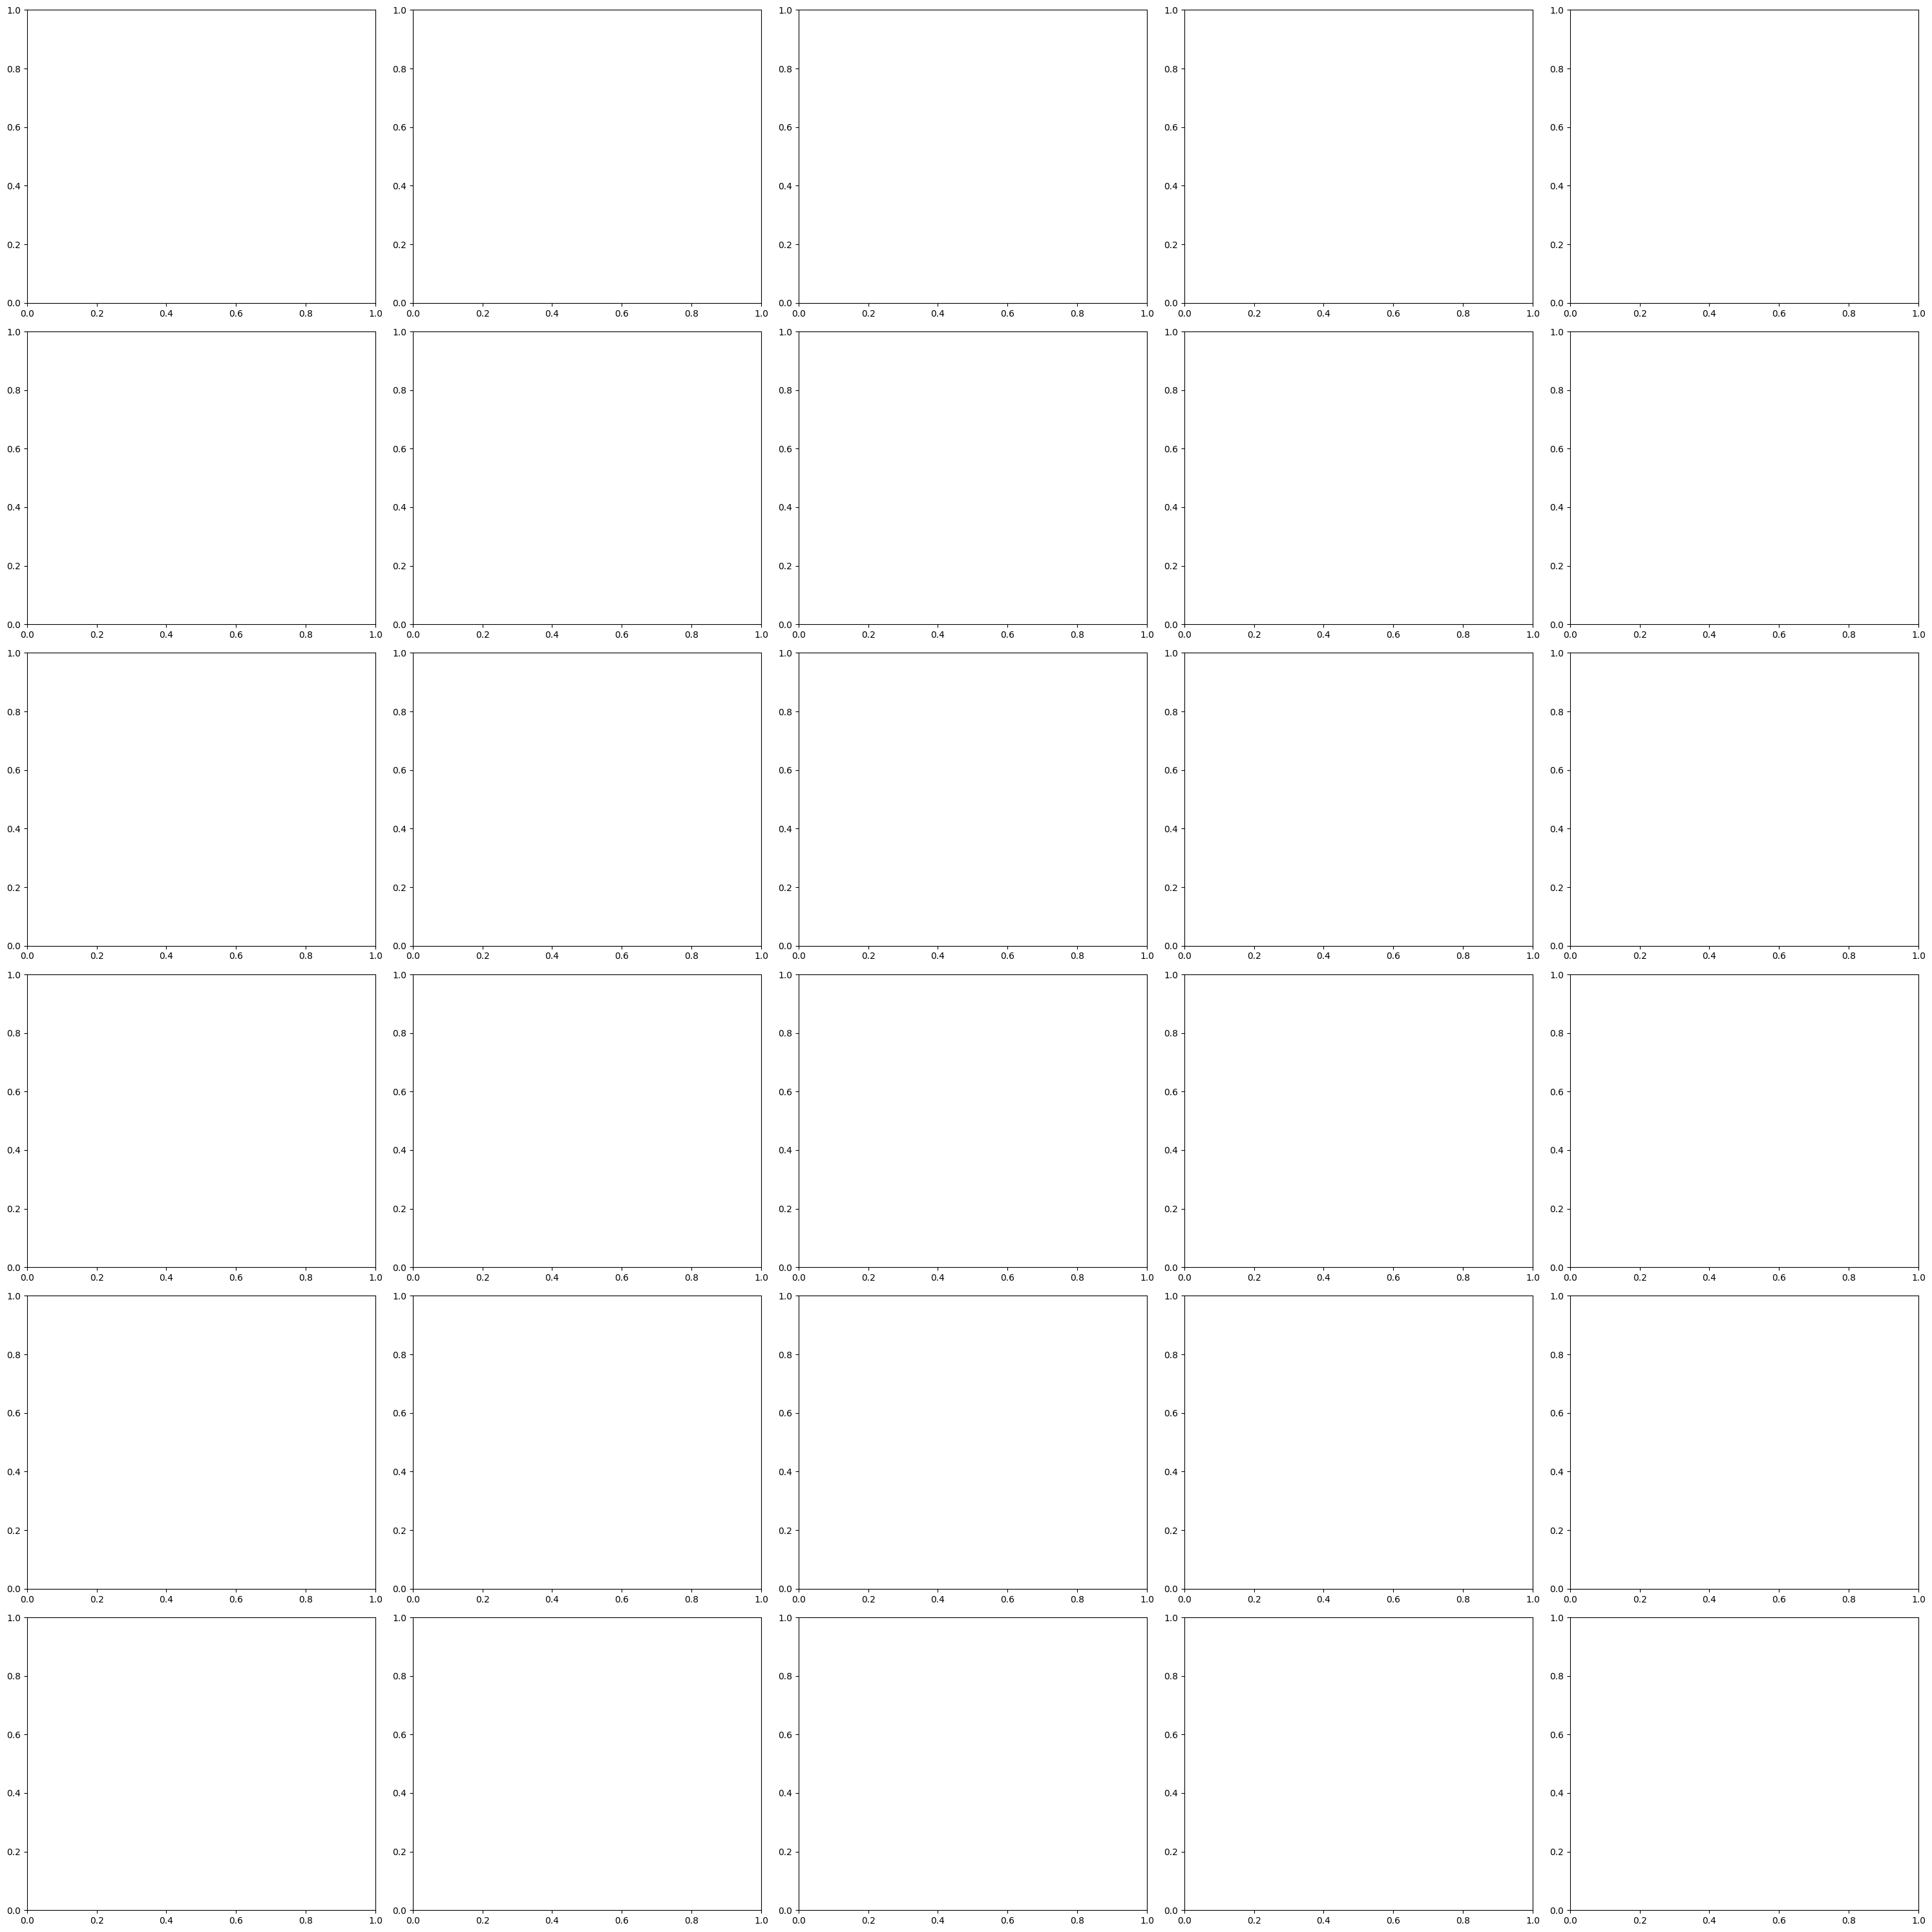

<ipython-input-11-c8dcb6a94a8e>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['Weighted CPU Max 1'] = table['Weighted CPU Max 1'].apply(lambda x: x*100)
<ipython-input-11-c8dcb6a94a8e>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['Weighted CPU Max 1'] = table['Weighted CPU Max 1'].round(2).astype(str) + '%'
<ipython-input-11-c8dcb6a94a8e>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,Site,Hardware,Weighted CPU Max 1,Weighted Capacity Max 1
Node,,,,
NSDP01,Obour,HP ProLiant DL360p Gen8,131.0%,5.135100e+03
NSDP02,Obour,HP ProLiant DL360p Gen8,143.34%,5.619030e+03
NSDP03,Obour,HP ProLiant DL360p Gen8,1.0120608154915407e+18%,3.967278e+19
NSDP04,Obour,HP ProLiant DL360p Gen8,130.5%,5.115730e+03
NSDP05,Obour,HP ProLiant DL360p Gen8,11.08%,4.344500e+02
NSDP06,October1st,HP ProLiant DL360p Gen8,146.86%,5.756910e+03
NSDP07,October1st,HP ProLiant DL360p Gen8,170.47%,6.682410e+03
NSDP08,October1st,HP ProLiant DL360p Gen8,164.42%,6.445430e+03
NSDP09,October1st,HP ProLiant DL360p Gen8,134.64%,5.277690e+03


In [ ]:
current_install_base = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SDP Stats/Orange_SDP_InstallBase.csv")
current_install_base.set_index('Node',inplace = True)
current_install_base["Mean Weighted CPU"] = np.nan
current_install_base["Mean Weighted Capacity"] = np.nan
current_install_base["Weighted CPU Max Time 1"] = np.nan
current_install_base["Weighted CPU Max 1"] = np.nan
current_install_base["Weighted Capacity Max 1"] = np.nan
current_install_base["Weighted CPU Max Time 2"] = np.nan
current_install_base["Weighted CPU Max 2"] = np.nan
current_install_base["Weighted Capacity Max 2"] = np.nan
current_install_base["Thrput-SMS Max Time"] = np.nan
current_install_base["Thrput-USSD Max Time"] = np.nan
current_install_base["Thrput-SMS Max 1"] = np.nan
current_install_base["Thrput-USSD Max 1"] = np.nan

rows = int(len(current_install_base.index) / 5) + (len(current_install_base.index) % 5 > 0)

X = 0
Y = 0

fig, axs = plt.subplots(rows-1, 5, figsize=(30,30))


for sdp, row in current_install_base.iterrows():
    try:

      SDPweightedData = getSDPweightedData(sdp,row['SDP CPU Capacity'])
      current_install_base.loc[sdp,'Mean Weighted CPU'] = SDPweightedData['Weighted CPU'].mean()
      current_install_base.loc[sdp,'Mean Weighted Capacity'] = SDPweightedData['Weighted Capacity'].mean()
      Weighted_CPU_Df = SDPweightedData['Weighted CPU'].nlargest(2).to_frame()
      i = 1
      for index, row in Weighted_CPU_Df.iterrows():
        current_install_base.loc[sdp,'Weighted CPU Max Time ' + str(i)] = index
        current_install_base.loc[sdp,'Weighted CPU Max ' + str(i)] =  row['Weighted CPU']
        i = i + 1

      Weighted_CPU_Cap_Df = SDPweightedData['Weighted Capacity'].nlargest(2).to_frame()
      i = 1
      for index, row in Weighted_CPU_Cap_Df.iterrows():
        current_install_base.loc[sdp,'Weighted Capacity Max ' + str(i)] =  row['Weighted Capacity']
        i = i + 1

      Max_SMS = SDPweightedData['Thrput-SMS'].nlargest(1).to_frame()
      i = 1
      for index, row in Max_SMS.iterrows():
        current_install_base.loc[sdp,'Thrput-SMS Max Time'] =  index
        current_install_base.loc[sdp,'Thrput-SMS Max 1'] =  row['Thrput-SMS']
        i = i + 1

      Max_USSD = SDPweightedData['Thrput-USSD'].nlargest(1).to_frame()
      i = 1
      for index, row in Max_USSD.iterrows():
        current_install_base.loc[sdp,'Thrput-USSD Max Time'] =  index
        current_install_base.loc[sdp,'Thrput-USSD Max 1'] =  row['Thrput-USSD']
        i = i + 1

      #Add Plot
      #two_scales(axs[X][Y], SDPweightedData.index, "Date/Time", SDPweightedData[['Weighted CPU']] * 100, "Weighted CPU", SDPweightedData[['Diameter_Reject']], "Diameter Reject", "#0000FF", "#FF0000" ,"Capacity Analysis for SDP: " + sdp)

      if Y<4:
        Y = Y + 1
      else:
        Y=0
        X = X + 1
    except:
      logging.warning('Run Failed for SDP: ' + sdp)

fig.tight_layout()


plt.show()
fig.savefig('SDPCapacityAnalysis.jpg')
table  = current_install_base[["Site", "Hardware","Weighted CPU Max 1", "Weighted Capacity Max 1"]]
table['Weighted CPU Max 1'] = table['Weighted CPU Max 1'].apply(lambda x: x*100)
table['Weighted CPU Max 1'] = table['Weighted CPU Max 1'].round(2).astype(str) + '%'
table['Weighted Capacity Max 1'] = table['Weighted Capacity Max 1'].round(2)
table

In [ ]:
current_install_base

,Site,Hardware,SDP Database Size,SDP CPU Capacity,Mean Weighted CPU,Mean Weighted Capacity,Weighted CPU Max Time 1,Weighted CPU Max 1,Weighted Capacity Max 1,Weighted CPU Max Time 2,Weighted CPU Max 2,Weighted Capacity Max 2,Thrput-SMS Max Time,Thrput-USSD Max Time,Thrput-SMS Max 1,Thrput-USSD Max 1
Node,,,,,,,,,,,,,,,,
NSDP01,Obour,HP ProLiant DL360p Gen8,15,3920,9.469205e-01,3.711928e+03,2023-05-21 22:01:30,1.309974e+00,5.135096e+03,2023-05-21 22:22:20,1.308148,5127.938576,2023-05-22 03:55:10,2023-05-21 22:01:50,5.800000e+01,63.0
NSDP02,Obour,HP ProLiant DL360p Gen8,15,3920,1.035798e+00,4.060327e+03,2023-05-21 22:22:40,1.433427e+00,5.619032e+03,2023-05-21 22:22:50,1.405935,5511.263424,2023-05-22 00:00:10,2023-05-21 21:03:30,2.800000e+01,68.0
NSDP03,Obour,HP ProLiant DL360p Gen8,15,3920,1.299680e+12,5.094746e+15,2023-05-22 05:45:30,1.012061e+16,3.967278e+19,2023-05-21 22:22:30,1.302181,5104.550489,2023-05-22 05:45:30,2023-05-21 20:42:00,1.983639e+20,59.0
NSDP04,Obour,HP ProLiant DL360p Gen8,15,3920,9.651732e-01,3.783479e+03,2023-05-21 22:32:40,1.305032e+00,5.115727e+03,2023-05-21 22:32:50,1.301604,5102.285922,2023-05-22 03:55:40,2023-05-21 20:41:00,3.800000e+01,64.0
NSDP05,Obour,HP ProLiant DL360p Gen8,15,3920,7.148971e-02,2.802396e+02,2023-05-21 22:13:40,1.108278e-01,4.344451e+02,2023-05-21 22:13:50,0.107889,422.923147,2023-05-22 00:00:10,2023-05-21 21:26:10,2.000000e+00,5.0
NSDP06,October1st,HP ProLiant DL360p Gen8,15,3920,1.093094e+00,4.284928e+03,2023-05-21 21:07:10,1.468600e+00,5.756911e+03,2023-05-21 22:27:00,1.464147,5739.457233,2023-05-22 00:00:10,2023-05-21 20:22:00,3.300000e+01,70.0
NSDP07,October1st,HP ProLiant DL360p Gen8,15,3920,1.006945e+00,3.947225e+03,2023-05-22 00:25:20,1.704696e+00,6.682410e+03,2023-05-22 00:55:20,1.457102,5711.839306,2023-05-22 03:55:00,2023-05-21 20:33:20,3.100000e+01,69.0
NSDP08,October1st,HP ProLiant DL360p Gen8,15,3920,1.035184e+00,4.057921e+03,2023-05-22 00:45:50,1.644243e+00,6.445434e+03,2023-05-21 22:22:30,1.536337,6022.440436,2023-05-22 03:55:10,2023-05-21 20:42:30,3.600000e+01,74.0
NSDP09,October1st,HP ProLiant DL360p Gen8,15,3920,9.750101e-01,3.822039e+03,2023-05-21 22:13:00,1.346350e+00,5.277692e+03,2023-05-21 22:17:30,1.342842,5263.938952,2023-05-22 03:55:00,2023-05-21 21:57:50,4.900000e+01,65.0


<Figure size 640x480 with 0 Axes>

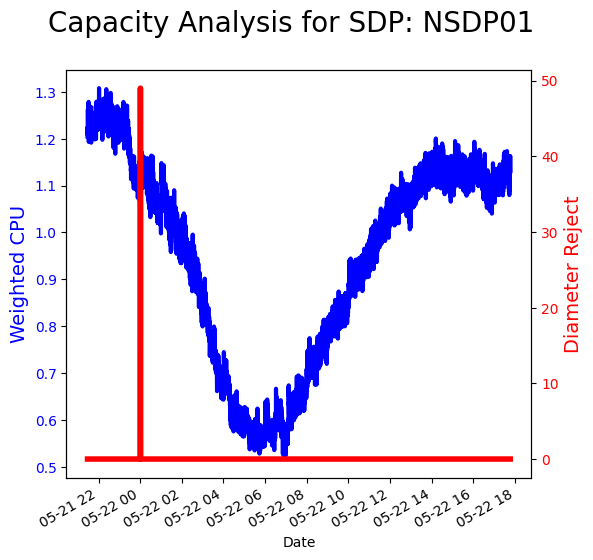

<Figure size 640x480 with 0 Axes>

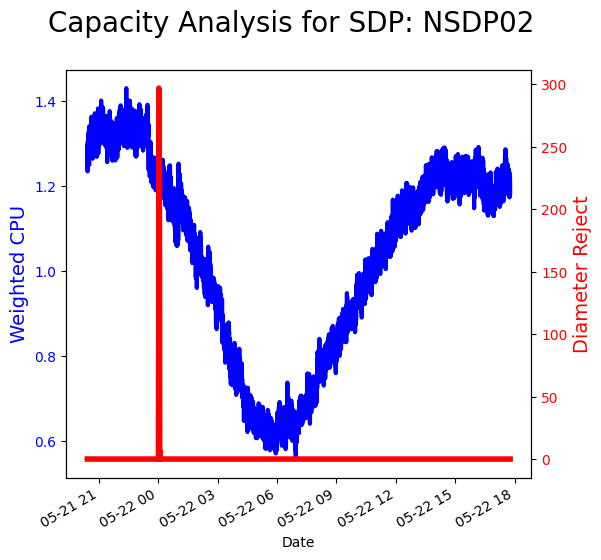

,Site,Hardware,SDP Database Size,SDP CPU Capacity,Mean Weighted CPU,Mean Weighted Capacity,Weighted CPU Max Time 1,Weighted CPU Max 1,Weighted Capacity Max 1,Weighted CPU Max Time 2,Weighted CPU Max 2,Weighted Capacity Max 2
Node,,,,,,,,,,,,
NSDP01,Obour,HP ProLiant DL360p Gen8,15,3920,0.945410,3706.006382,2023-05-21 22:01:30,1.307756,5126.404143,2023-05-21 22:22:20,1.305596,5117.934576
NSDP02,Obour,HP ProLiant DL360p Gen8,15,3920,1.034249,4054.257556,2023-05-21 22:22:40,1.430686,5608.290242,2023-05-21 22:22:50,1.403403,5501.341424
NSDP03,Obour,HP ProLiant DL360p Gen8,15,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NSDP04,Obour,HP ProLiant DL360p Gen8,15,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NSDP05,Obour,HP ProLiant DL360p Gen8,15,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NSDP06,October1st,HP ProLiant DL360p Gen8,15,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NSDP07,October1st,HP ProLiant DL360p Gen8,15,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NSDP08,October1st,HP ProLiant DL360p Gen8,15,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NSDP09,October1st,HP ProLiant DL360p Gen8,15,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
current_install_base = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SDP Stats/Orange_SDP_InstallBase.csv")
current_install_base.set_index('Node',inplace = True)
current_install_base["Mean Weighted CPU"] = np.nan
current_install_base["Mean Weighted Capacity"] = np.nan
current_install_base["Weighted CPU Max Time 1"] = np.nan
current_install_base["Weighted CPU Max 1"] = np.nan
current_install_base["Weighted Capacity Max 1"] = np.nan
current_install_base["Weighted CPU Max Time 2"] = np.nan
current_install_base["Weighted CPU Max 2"] = np.nan
current_install_base["Weighted Capacity Max 2"] = np.nan

X = 0
Y = 0

for sdp, row in current_install_base.head(2).iterrows():
    #try:
      SDPweightedData = getSDPweightedData(sdp,row['SDP CPU Capacity'])
      current_install_base.loc[sdp,'Mean Weighted CPU'] = SDPweightedData['Weighted CPU'].mean()
      current_install_base.loc[sdp,'Mean Weighted Capacity'] = SDPweightedData['Weighted Capacity'].mean()
      Weighted_CPU_Df = SDPweightedData['Weighted CPU'].nlargest(2).to_frame()
      i = 1
      for index, row in Weighted_CPU_Df.iterrows():
        current_install_base.loc[sdp,'Weighted CPU Max Time ' + str(i)] = index
        current_install_base.loc[sdp,'Weighted CPU Max ' + str(i)] =  row['Weighted CPU']
        i = i + 1

      Weighted_CPU_Cap_Df = SDPweightedData['Weighted Capacity'].nlargest(2).to_frame()
      i = 1
      for index, row in Weighted_CPU_Cap_Df.iterrows():
        current_install_base.loc[sdp,'Weighted Capacity Max ' + str(i)] =  row['Weighted Capacity']
        i = i + 1

      #Add Plot

      COLOR_TEMPERATURE = "#0000FF"
      COLOR_PRICE = "#FF0000"

      bigfig = plt.figure()

      fig, ax1 = plt.subplots(figsize=(6,6))
      ax2 = ax1.twinx()

      ax1.plot(SDPweightedData.index, SDPweightedData[['Weighted CPU']], color=COLOR_TEMPERATURE, lw=3)
      ax2.plot(SDPweightedData.index, SDPweightedData[['Diameter_Reject']], color=COLOR_PRICE, lw=4)

      ax1.set_xlabel("Date")
      ax1.set_ylabel("Weighted CPU", color=COLOR_TEMPERATURE, fontsize=14)
      ax1.tick_params(axis="y", labelcolor=COLOR_TEMPERATURE)

      ax2.set_ylabel("Diameter Reject", color=COLOR_PRICE, fontsize=14)
      ax2.tick_params(axis="y", labelcolor=COLOR_PRICE)

      fig.suptitle("Capacity Analysis for SDP: " + sdp, fontsize=20)
      fig.autofmt_xdate()

      if X <= 5:
        X = X + 1
      else:
        X = 0

      if Y<=6:
        Y = Y + 1
      else:
        Y=0


plt.show(block=True)

      #WeightedCPUPlot = SDPweightedData[['Weighted CPU']]
      #WeightedCPUPlot.plot.line(title="Weighted CPU for SDP: " + sdp)
      #plot.show(block=True)

    #except:
    #  logging.warning('Run Failed for SDP: ' + sdp)


current_install_base